In [2]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")

from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)
dataset
dates = dataset['calculation_date'].copy().squeeze().drop_duplicates().reset_index(drop=True)


##################
# training start #
##################

Fri Nov  1 16:37:23 2024



100%|█████████████████████████████████████████████████████████████████████████████████| 2102/2102 [00:08<00:00, 242.12it/s]


In [3]:
days = dates.dt.round('D').drop_duplicates()
latest = days.iloc[:10]
ante = days.iloc[10:19]
nspots=1
development_dates = dates[dates.dt.normalize().isin(ante)]#.iloc[-nspots:]
test_dates = dates[dates.dt.normalize().isin(latest)]#.iloc[:nspots]
print(len(development_dates),len(test_dates))

158 140


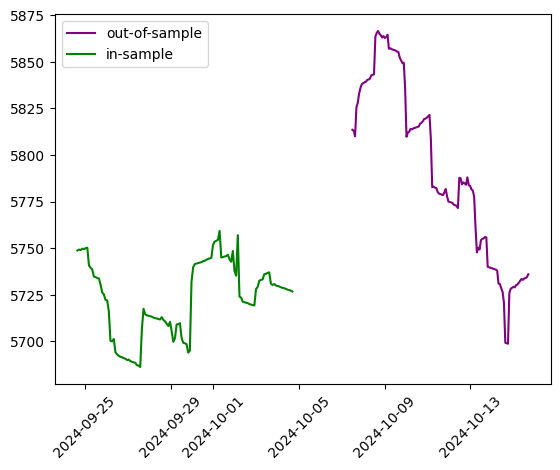

329507 329507


In [4]:
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]

train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()

trainplotx = pd.date_range(start=min(train_plot.index),end=max(train_plot.index),periods=len(train_plot))
testplotx = pd.date_range(start=min(test_plot.index),end=max(test_plot.index),periods=len(test_plot))

plt.figure()
plt.xticks(rotation=45)
plt.plot(testplotx,test_plot,color='purple',label='out-of-sample')
plt.plot(trainplotx,train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
print(len(train_y),len(train_X))

## stacked regressor

In [5]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [6]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 'barrier',
    'v0',
    'theta',
    'kappa',
]

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)

ridge_pipeline = make_pipeline(ridge_preprocessor, RidgeCV())

test_ridge = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

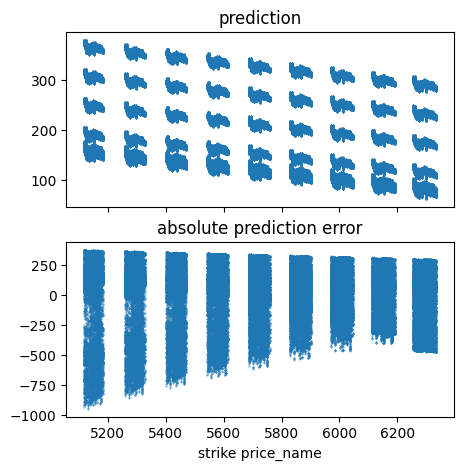


train spots:
calculation_date
2024-10-04 16:30:45.239   5686.25000
2024-10-04 16:30:45.239   5687.00000
2024-10-04 16:29:50.416   5687.25000
2024-10-04 16:28:59.519   5688.50000
2024-10-04 16:27:40.659   5688.75000
                             ...    
2024-09-24 15:55:37.843   5753.50000
2024-09-24 15:55:08.965   5754.00000
2024-09-24 15:55:08.155   5754.50000
2024-09-24 15:38:32.741   5757.00000
2024-09-24 14:33:01.669   5759.25000
Name: spot_price, Length: 131, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'barrier',
                                                                                        'v0',
                                                                                        'theta',
                                                                                        'kappa'])])),
                                                     ('ridgecv', RidgeCV())]),
                           transformer=StandardScaler())

In [7]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price_name')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_scaler,trainer.numerical_features),
        ('categorical',OneHotEncoder(),trainer.categorical_features)
    ]
)

mlp_pipeline = make_pipeline(preprocessor,MLPRegressor(**trainer.dnn_params))
stacked_regressor = StackingRegressor(estimators=[('dnn',mlp_pipeline),('ridge',ridge_pipeline)],final_estimator=GradientBoostingRegressor())
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
print(meta)

TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('dnn',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('numerical',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
        

In [9]:
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__dnn__mlpregressor__alpha': [0.1,0.01,0.001,0.0001]
    'regressor__dnn__mlpregressor__early_stopping': [False, True],
    'regressor__dnn__mlpregressor__learning_rate': ['constant', 'adaptive','invscaling'],
    'regressor__dnn__mlpregressor__warm_start': [True, False],
    'regressor__dnn__mlpregressor__solver':['sgd','lbfgs'],
    'regressor__dnn__mlpregressor__learning_rate_init':[0.1,0.01,0.001]
}

grid_search = GridSearchCV(meta, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_X, train_y)

best_meta = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters for DNN:", best_params)
print("Best Meta Model with Tuned DNN:", best_meta)

In [ ]:
meta.fit(train_X,train_y)
P = meta.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
print(f"\n\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
testP = meta.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

### versus original

In [ ]:
dnn = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
P = dnn.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"\n\nin sample:\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
P = dnn.predict(test_X)
diff = test_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")